In [1]:
import numpy as np
from scipy.linalg import null_space, orth, svd, qr, subspace_angles
import matplotlib.pyplot as plt
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True)
model.eval()

embeddings = model.wte.weight.data

print("Model name:", model.config.name_or_path)
print("Tokenizer:", tokenizer.name_or_path)
print("Vocabulary size:", tokenizer.vocab_size)
print("Embedding dimensions:", model.config.hidden_size)
print("Number of attention layers:", model.config.num_hidden_layers)

/home/miotto/miniconda3/envs/transformers/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model name: gpt2
Tokenizer: gpt2
Vocabulary size: 50257
Embedding dimensions: 768
Number of attention layers: 12


In [2]:
state_dict = model.state_dict()

WQ = torch.empty(12, 12, 768, 64)
WK = torch.empty_like(WQ)

bQ = torch.empty(12, 12, 64)
bK = torch.empty_like(bQ)

for layer in range(12):
    # [768, 2304] → chunk into [768, 768] each
    _WQ, _WK, _ = state_dict[f'h.{layer}.attn.c_attn.weight'].chunk(3, dim=1)
    _bQ, _bK, _ = state_dict[f'h.{layer}.attn.c_attn.bias'].chunk(3, dim=0)

    _h_WQ = _WQ.chunk(12, dim=1)
    _h_WK = _WK.chunk(12, dim=1)
    _h_bQ = _bQ.chunk(12, dim=0)
    _h_bK = _bK.chunk(12, dim=0)

    for head in range(12):
        WQ[layer, head] = _h_WQ[head]
        WK[layer, head] = _h_WK[head]
        bQ[layer, head] = _h_bQ[head]
        bK[layer, head] = _h_bK[head]

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

In [6]:
layer = 0
head = 0

WQ_layer_head = WQ[layer, head]
WK_layer_head = WK[layer, head]

In [7]:
def tsne_from_bases(bases, basis_labels, N=500, tsne_perplexity=100):
    """
    Given a list of orthonormal bases, sample N vectors from each, normalize, and compute t-SNE.
    Args:
        bases: list of np.ndarray, each of shape (d, k)
        basis_labels: list of str, label for each basis
        N: int, number of samples per basis
        tsne_perplexity: int, t-SNE perplexity
    Returns:
        X_tsne: np.ndarray, t-SNE embedding
        labels: list of str, labels for each sample
    """
    vectors = []
    labels = []
    for basis, label in zip(bases, basis_labels):
        # Sample N random vectors from the basis
        vecs = (basis @ np.random.randn(basis.shape[1], N)).T
        vectors.append(vecs)
        labels.extend([label] * N)
    X = np.vstack(vectors)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    X = StandardScaler().fit_transform(X)  # Normalize to zero mean, unit variance
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, metric='cosine', random_state=42, init='pca')
    X_tsne = tsne.fit_transform(X)
    return X_tsne, labels

def plot_tsne(X_tsne, labels):
    """
    Plots a t-SNE embedding with colored labels.
    Args:
        X_tsne: np.ndarray, shape (n_samples, 2)
        labels: list of str, label for each sample
        color_map: dict, mapping label -> color (optional, autogenerated if None)
        title: str, plot title
        xlabel: str, x-axis label
        ylabel: str, y-axis label
        legend_labels: list of tuples (label, color, display_name), optional
        figsize: tuple, figure size
        dpi: int, figure dpi
    """
    unique_labels = sorted(set(labels))
    cmap = plt.get_cmap('tab10' if len(unique_labels) <= 10 else 'hsv')
    color_map = {label: cmap(i % cmap.N) for i, label in enumerate(unique_labels)}
    colors = [color_map[label] for label in labels]
    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=50, alpha=0.6)
    legend_labels = [(label, color_map[label], label) for label in unique_labels]
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=display_name, markerfacecolor=color, markersize=10)
        for _, color, display_name in legend_labels
    ]
    plt.legend(handles=legend_elements)
    plt.grid()
    plt.show()

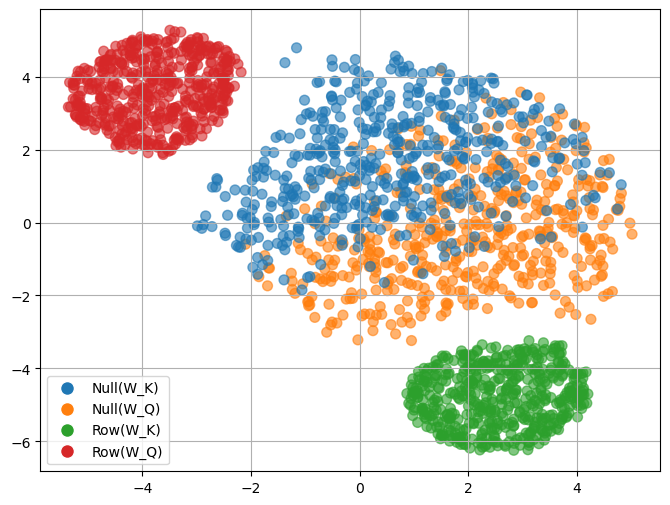

In [8]:
# Bases for WQ and WK
row_basis_Q = orth(WQ_layer_head)
null_basis_Q = null_space(WQ_layer_head.T)
row_basis_K = orth(WK_layer_head)
null_basis_K = null_space(WK_layer_head.T)

# Normalization
row_basis_K = row_basis_K / np.linalg.norm(row_basis_K, axis=0, keepdims=True)
null_basis_K = null_basis_K / np.linalg.norm(null_basis_K, axis=0, keepdims=True)
row_basis_Q = row_basis_Q / np.linalg.norm(row_basis_Q, axis=0, keepdims=True)
null_basis_Q = null_basis_Q / np.linalg.norm(null_basis_Q, axis=0, keepdims=True)


bases = [row_basis_Q, row_basis_K, null_basis_Q, null_basis_K]
basis_labels = ['Row(W_Q)', 'Row(W_K)', 'Null(W_Q)', 'Null(W_K)']
X_tsne, labels = tsne_from_bases(bases, basis_labels)

plot_tsne(X_tsne, labels)

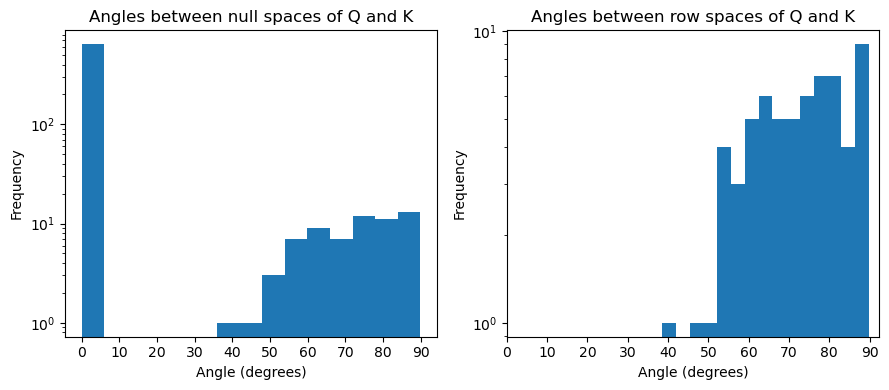

In [9]:
angles_null = subspace_angles(null_basis_Q, null_basis_K)
angles_deg_null = np.degrees(angles_null)
grassmann_distances_null = np.sqrt(np.sum(angles_null**2))

angles_row = subspace_angles(row_basis_Q, row_basis_K)
angles_deg_row = np.degrees(angles_row)
grassmann_distances_row = np.sqrt(np.sum(angles_row**2))

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].hist(angles_deg_null, bins=15)
axes[0].set_title("Angles between null spaces of Q and K")
axes[0].set_xlabel("Angle (degrees)")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale('log')
axes[0].set_xticks(np.arange(0, 91, 10))

axes[1].hist(angles_deg_row, bins=15)
axes[1].set_title("Angles between row spaces of Q and K")
axes[1].set_xlabel("Angle (degrees)")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale('log')
axes[1].set_xticks(np.arange(0, 91, 10))

plt.tight_layout()
plt.show()

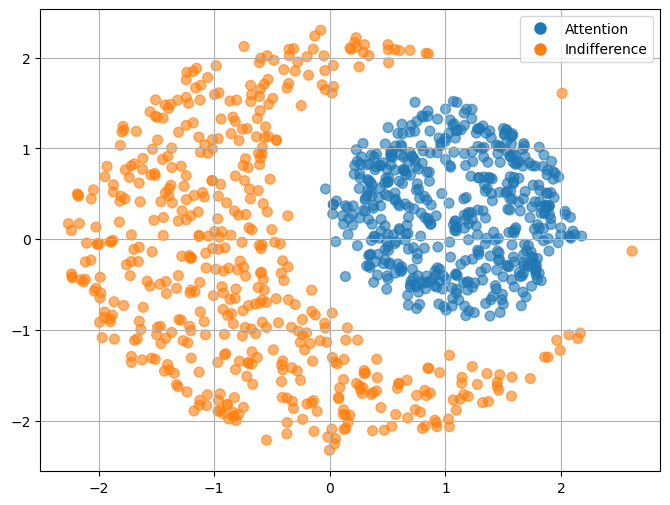

In [10]:
# Combine row and null space vectors

# Union of row spaces
Q, R = qr(np.concatenate([row_basis_Q, row_basis_K], axis=1), mode='economic')
n = np.linalg.matrix_rank(np.concatenate([row_basis_Q, row_basis_K], axis=1))
row_basis_QK = Q[:, :n]

# Union of null spaces
Q, R = qr(np.concatenate([null_basis_Q, null_basis_K], axis=1), mode='economic')
n = np.linalg.matrix_rank(np.concatenate([null_basis_Q, null_basis_K], axis=1))
null_basis_QK = Q[:, :n]

basis = [row_basis_QK, null_basis_QK]
labels = ['Attention', 'Indifference']
X_tsne, labels = tsne_from_bases(basis, labels)

plot_tsne(X_tsne, labels)

In [11]:
def null_row_basis(A : np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Computes the null space and row space of a matrix A.
    Args:
        A: np.ndarray, input matrix (n, m)
    Returns:
        null_space: np.ndarray (m, r), orthonormal basis for the null space of A
        row_space: np.ndarray (m, m - r), orthonormal basis for the row space of A
    """
    if A.shape[0] < A.shape[1]:
        A = A.T
    rank = np.linalg.matrix_rank(A)
    _, _, Vt = np.linalg.svd(A.T)
    null_space = Vt[rank:, :].T
    row_space = Vt[:rank, :].T
    return null_space, row_space

def grassmann_distance(A : np.ndarray, B : np.ndarray) -> float:
    """
    Computes the Grassmann distance between two subspaces A and B.
    Args:
        A: np.ndarray, orthonormal basis for subspace A
        B: np.ndarray, orthonormal basis for subspace B
    Returns:
        float, Grassmann distance between the two subspaces
    """
    from scipy.linalg import subspace_angles
    angles = subspace_angles(A, B)
    return np.sqrt(np.sum(angles**2))

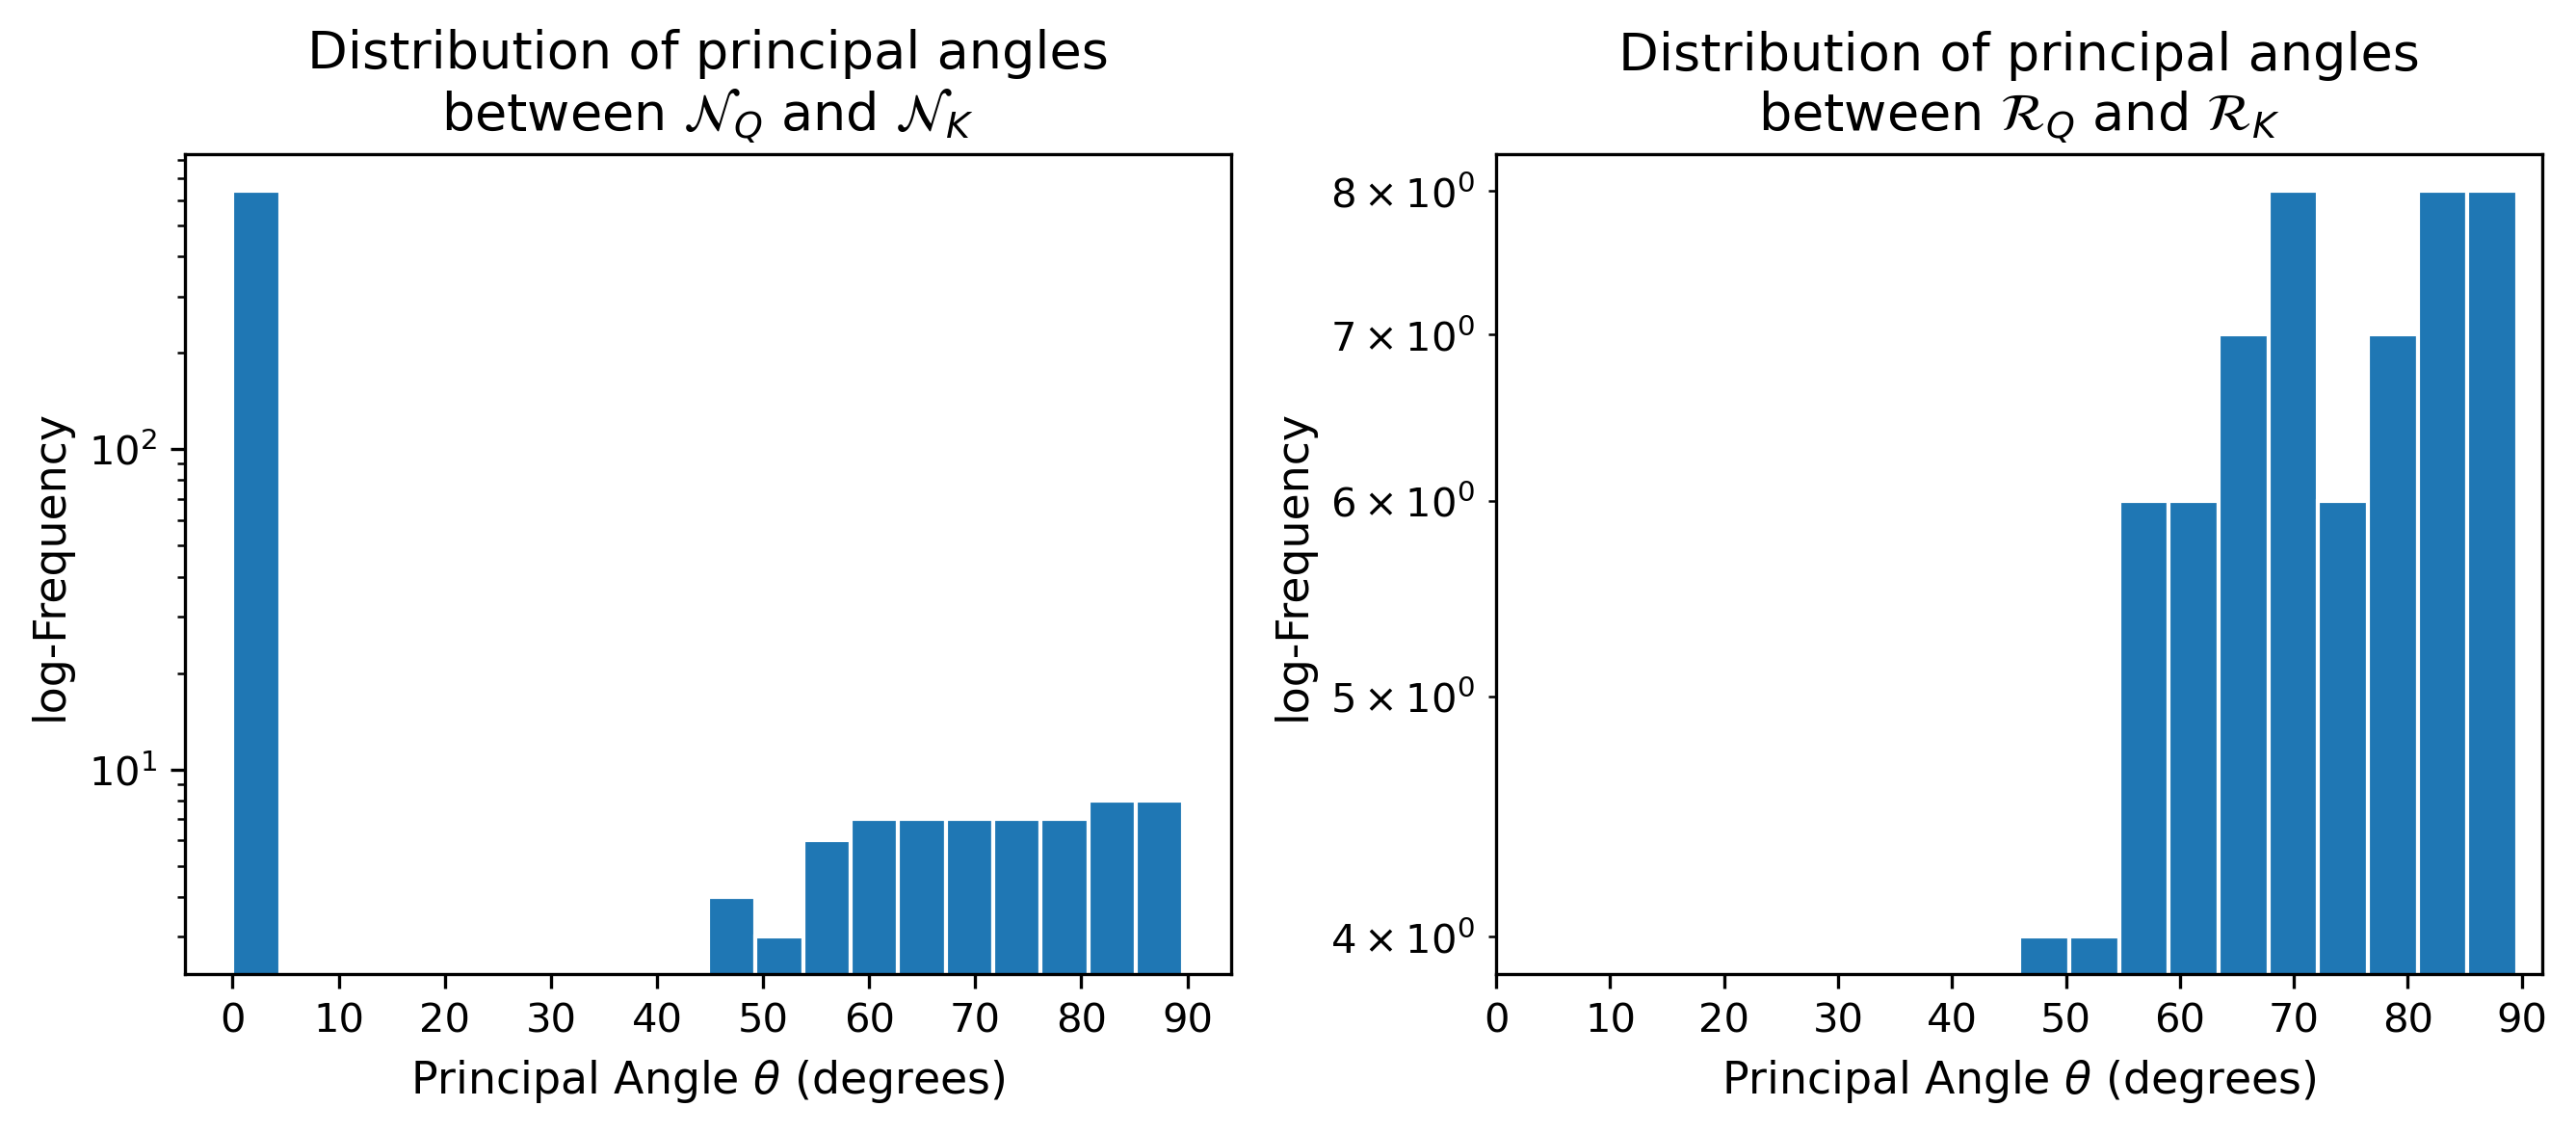

In [12]:
layer = 11
head = 5

WQ_layer_head = WQ[layer, head]
WK_layer_head = WK[layer, head]

NQ, RQ = null_row_basis(WQ_layer_head)
NK, RK = null_row_basis(WK_layer_head)

angles_NQ_NK = np.degrees(subspace_angles(NQ, NK))
angles_RQ_RK = np.degrees(subspace_angles(RQ, RK))

grassmann_distance_NQ_NK = grassmann_distance(NQ, NK)
grassmann_distance_RQ_RK = grassmann_distance(RQ, RK)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=300)

# Null space angles
axes[0].hist(angles_NQ_NK, bins=20, edgecolor='white')
axes[0].set_title("Distribution of principal angles\nbetween $\\mathcal{N}_Q$ and $\\mathcal{N}_K$", fontsize=13)
axes[0].set_xlabel("Principal Angle $\\theta$ (degrees)", fontsize=11)
axes[0].set_ylabel("log-Frequency", fontsize=11)
axes[0].set_yscale('log')
axes[0].set_xticks(np.arange(0, 91, 10))

# Row space angles
axes[1].hist(angles_RQ_RK, bins=10, edgecolor='white')
axes[1].set_title("Distribution of principal angles\nbetween $\\mathcal{R}_Q$ and $\\mathcal{R}_K$", fontsize=13)
axes[1].set_xlabel("Principal Angle $\\theta$ (degrees)", fontsize=11)
axes[1].set_ylabel("log-Frequency", fontsize=11)
axes[1].set_yscale('log')
axes[1].set_xticks(np.arange(0, 91, 10))

plt.tight_layout(pad=1.0)
plt.savefig("angles_distribution.pdf", dpi=300)
plt.show()


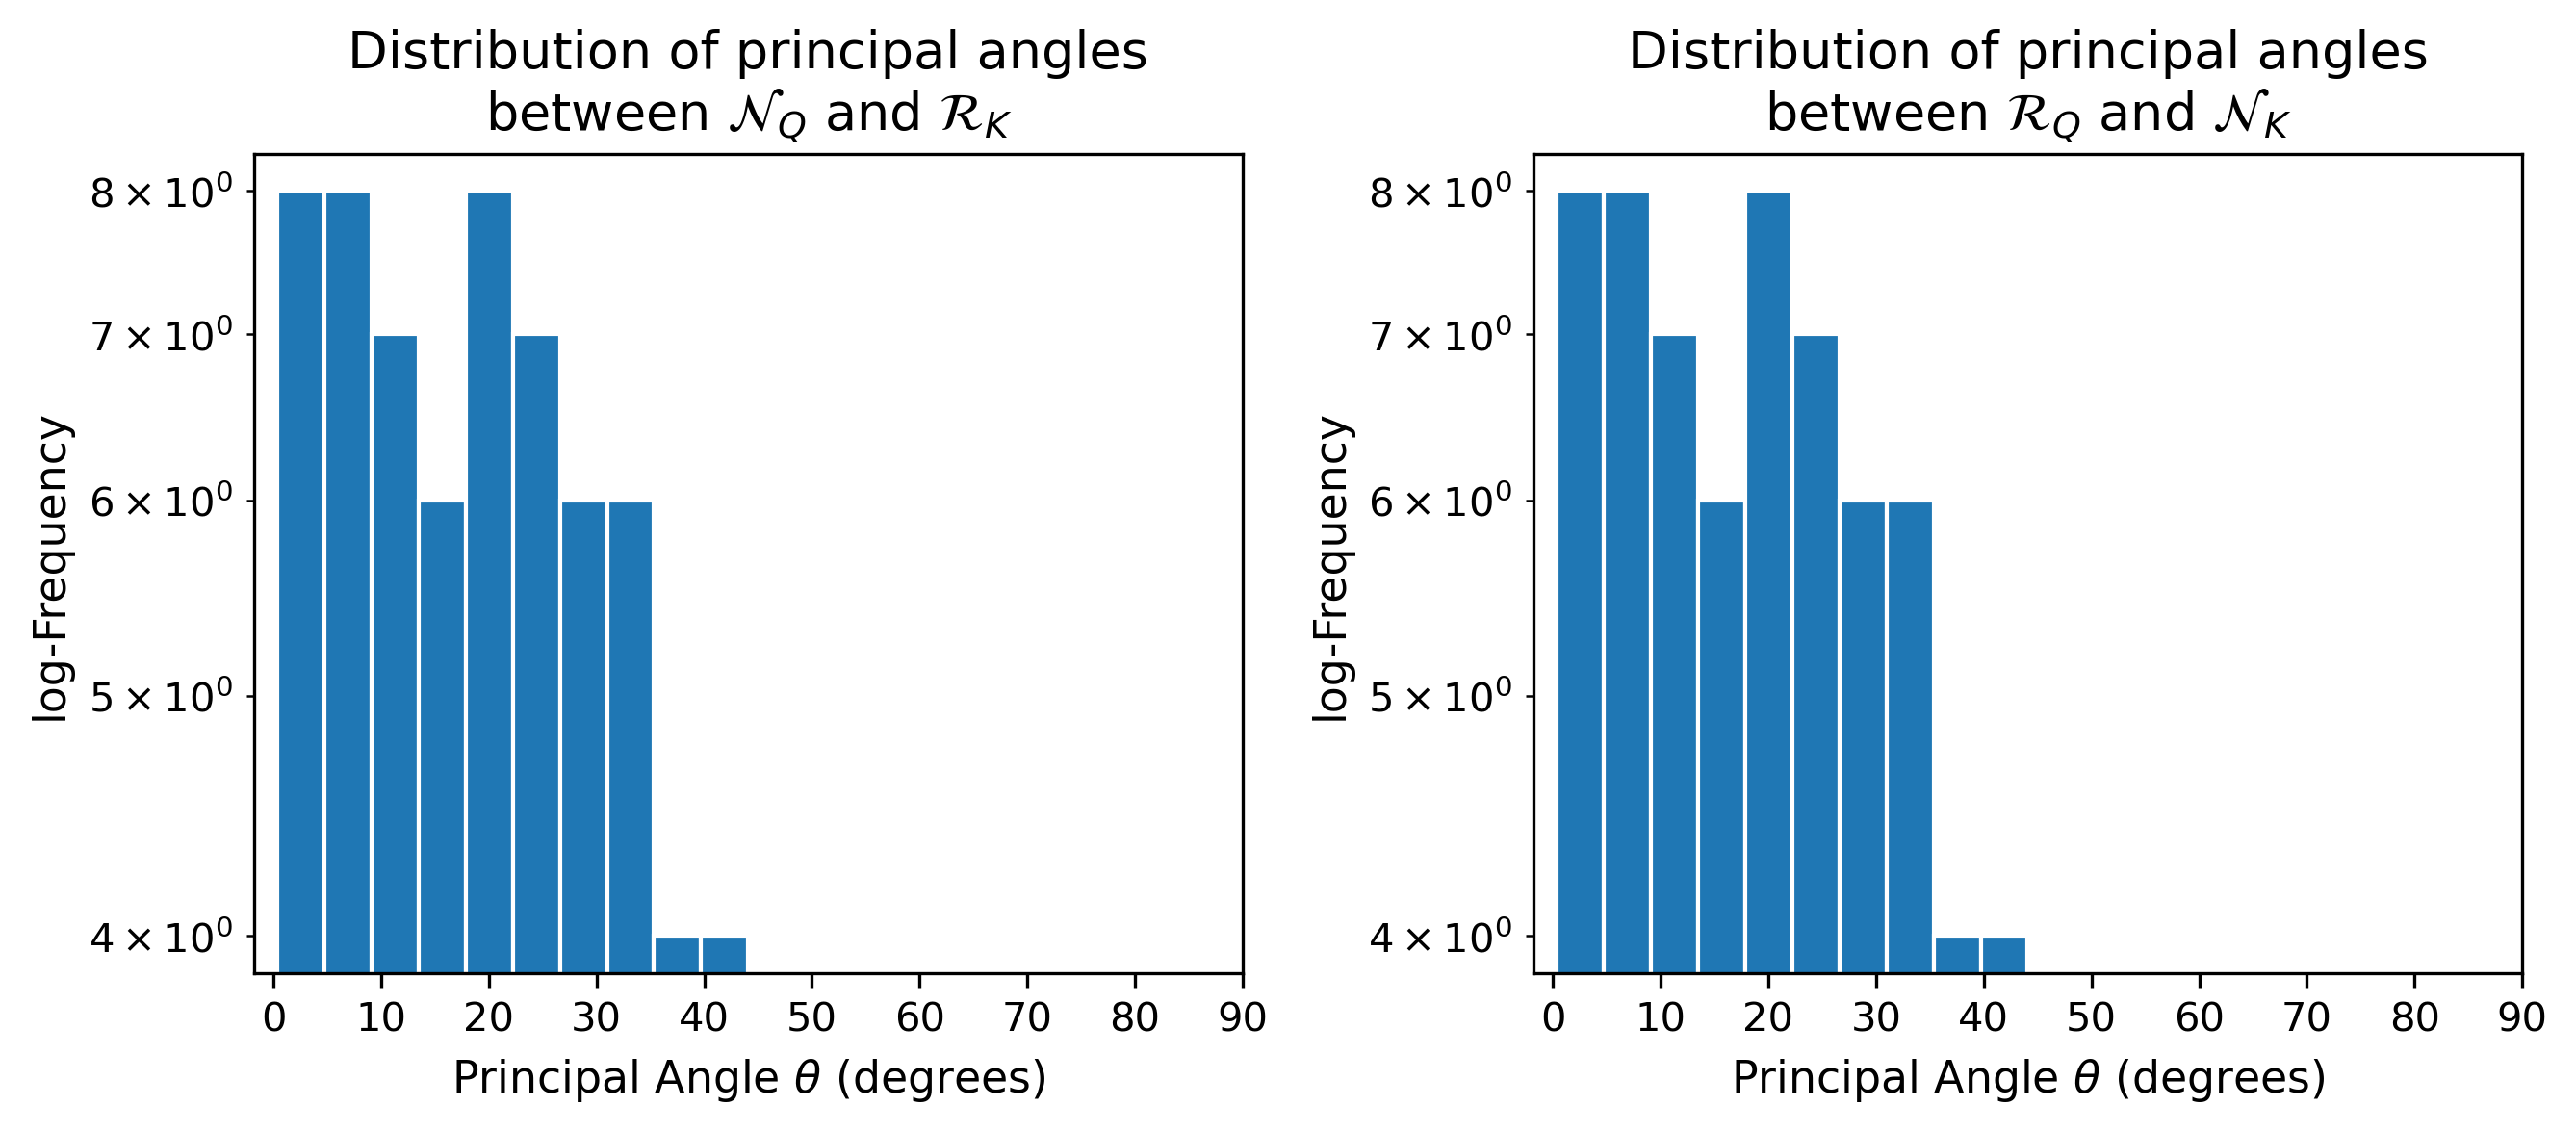

In [13]:
angles_NQ_RK = np.degrees(subspace_angles(NQ, RK))
angles_RQ_NK = np.degrees(subspace_angles(RQ, NK))

fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
# Null space vs Row space angles
axes[0].hist(angles_NQ_RK, bins=10, edgecolor='white')
axes[0].set_title("Distribution of principal angles\nbetween $\\mathcal{N}_Q$ and $\\mathcal{R}_K$", fontsize=13)
axes[0].set_xlabel("Principal Angle $\\theta$ (degrees)", fontsize=11)
axes[0].set_ylabel("log-Frequency", fontsize=11)
axes[0].set_yscale('log')
axes[0].set_xticks(np.arange(0, 91, 10))
# Row space vs Null space angles
axes[1].hist(angles_RQ_NK, bins=10, edgecolor='white')
axes[1].set_title("Distribution of principal angles\nbetween $\\mathcal{R}_Q$ and $\\mathcal{N}_K$", fontsize=13)
axes[1].set_xlabel("Principal Angle $\\theta$ (degrees)", fontsize=11)
axes[1].set_ylabel("log-Frequency", fontsize=11)
axes[1].set_yscale('log')
axes[1].set_xticks(np.arange(0, 91, 10))
plt.tight_layout(pad=1.0)
plt.savefig("angles_distribution_cross.pdf", dpi=300)
plt.show()

In [14]:

bases = [RQ, RK, NQ, NK]
basis_labels = ['Row space $\\mathcal{R}_Q$', 'Row space $\\mathcal{R}_K$', 'Null space $\\mathcal{N}_Q$', 'Null space $\\mathcal{N}_K$']
X_tsne, labels = tsne_from_bases(bases, basis_labels, tsne_perplexity=80, N=400)


/tmp/ipykernel_2800/1543607404.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  vecs = (basis @ np.random.randn(basis.shape[1], N)).T


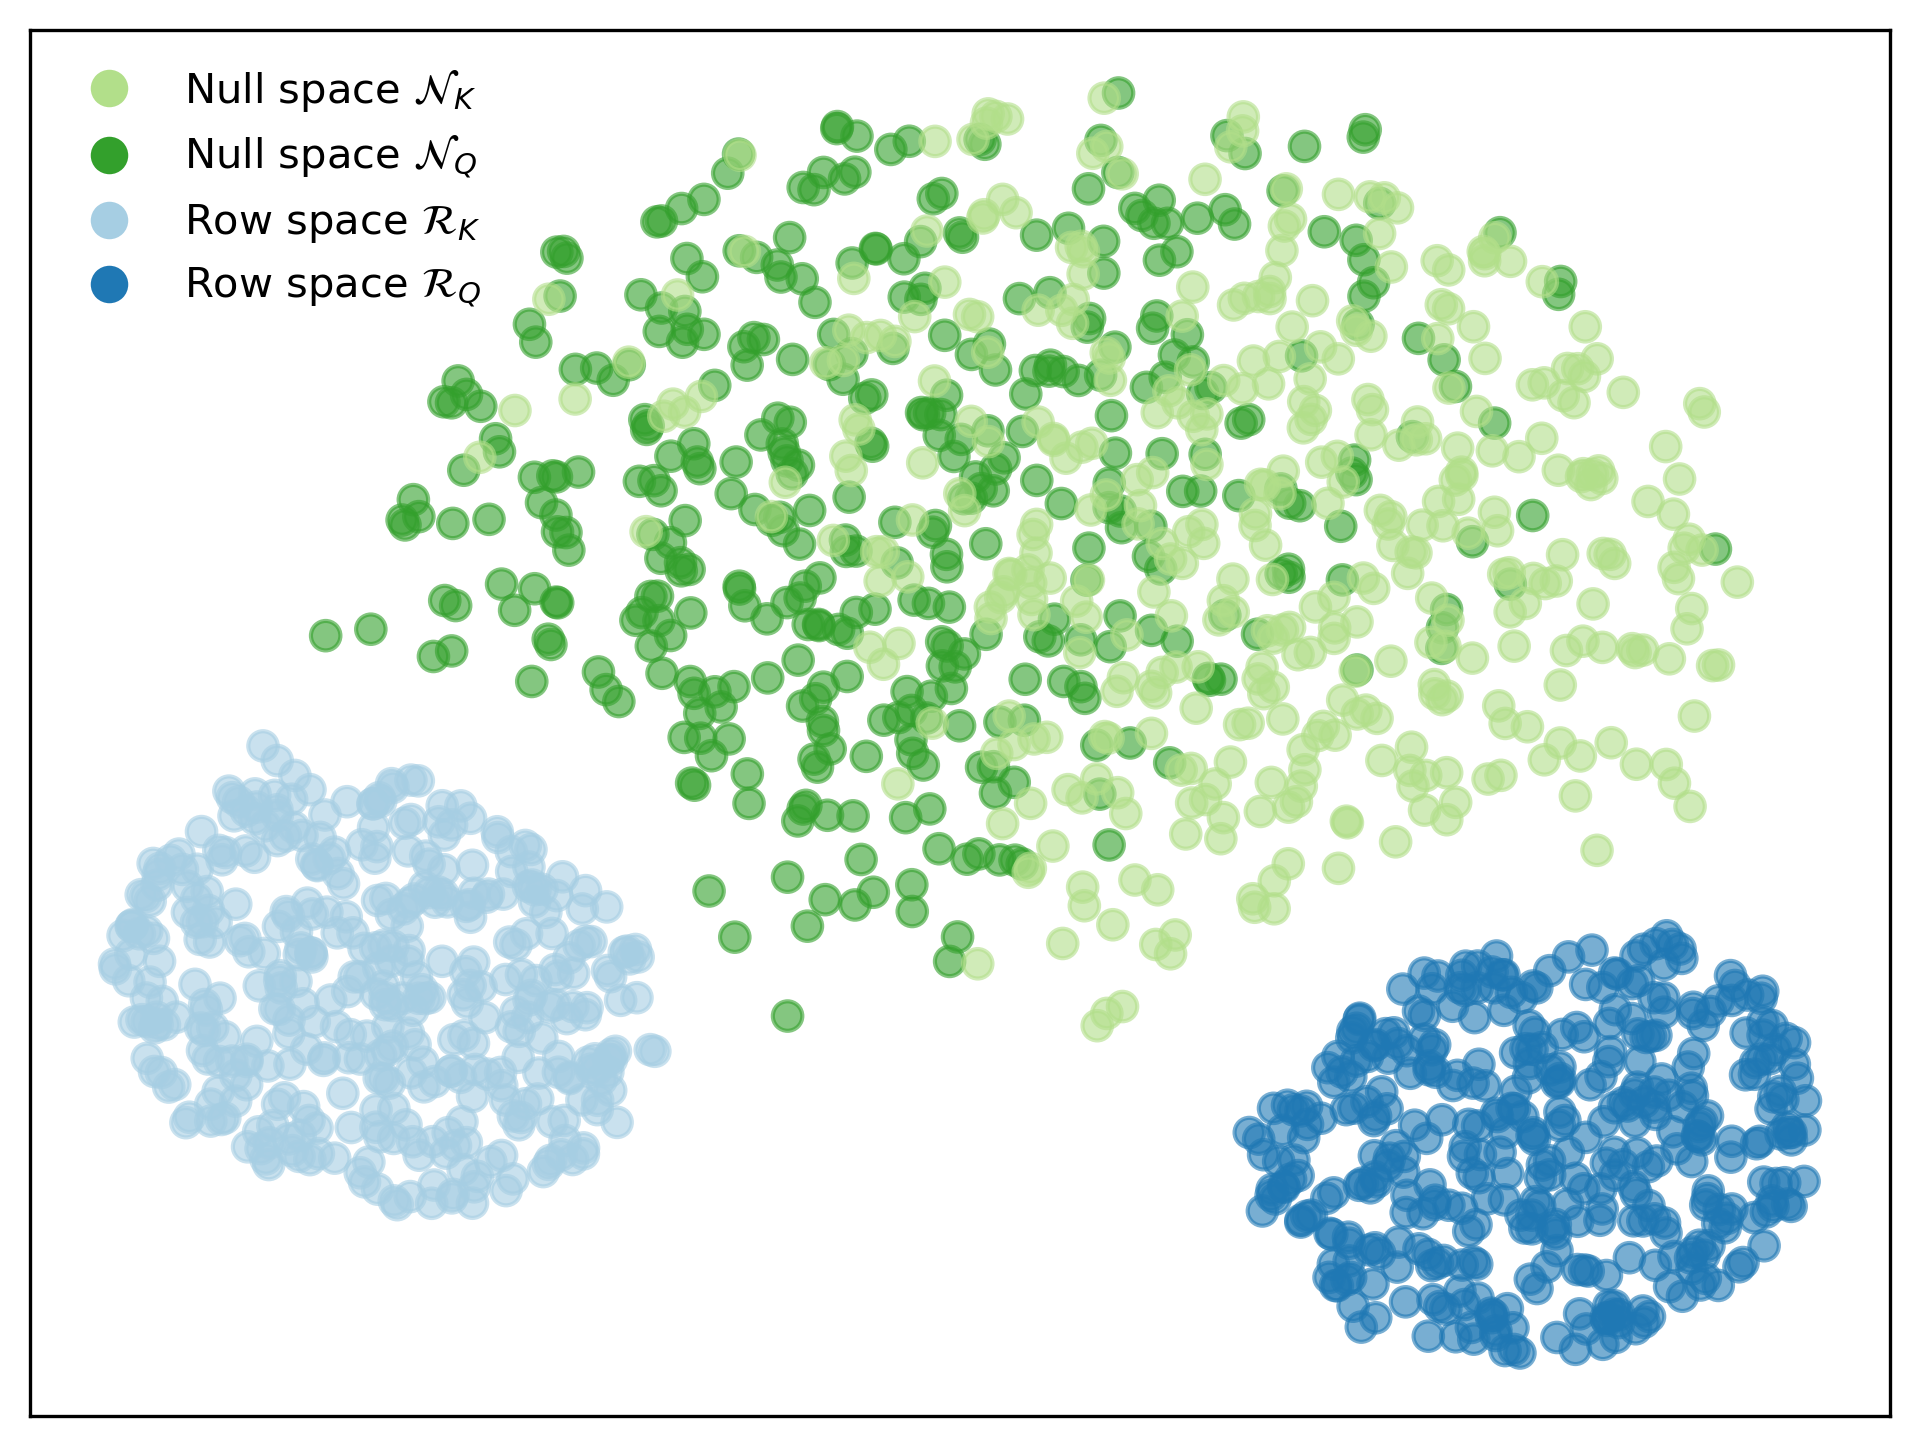

In [15]:
# Choose which pairs to use from the Paired colormap
# For example, use indices [0, 2, 4, 6] for the first four pairs
indices = [2, 3, 0, 1]  # Change this list as desired

unique_labels = sorted(set(labels))
cmap = plt.get_cmap('Paired' if len(unique_labels) <= 10 else 'hsv')

# If not enough indices are provided, repeat or truncate as needed
if len(indices) < len(unique_labels):
    indices = (indices * ((len(unique_labels) + len(indices) - 1) // len(indices)))[:len(unique_labels)]
elif len(indices) > len(unique_labels):
    indices = indices[:len(unique_labels)]

color_map = {label: cmap(i % cmap.N) for label, i in zip(unique_labels, indices)}
colors = [color_map[label] for label in labels]
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=50, alpha=0.6)
legend_labels = [(label, color_map[label], label) for label in unique_labels]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=display_name, markerfacecolor=color, markersize=10)
    for _, color, display_name in legend_labels
]
plt.legend(handles=legend_elements, fontsize=10, frameon=False)
plt.xticks([])
plt.yticks([])
plt.savefig("tsne_bases.pdf", dpi=300)
plt.show()

In [16]:
def union_subspace(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Computes the union of two subspaces A and B.
    Args:
        A: np.ndarray, orthonormal basis for subspace A
        B: np.ndarray, orthonormal basis for subspace B
    Returns:
        np.ndarray, orthonormal basis for the union of A and B
    """
    from scipy.linalg import orth
    M = np.hstack([A, B])
    return orth(M)

def intersection_subspace(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Computes the intersection of two subspaces A and B.
    Args:
        A: np.ndarray, orthonormal basis for subspace A
        B: np.ndarray, orthonormal basis for subspace B
    Returns:
        np.ndarray, orthonormal basis for the intersection of A and B
    """
    from scipy.linalg import orth, null_space
    M = np.hstack([A, -B])
    ns = null_space(M)
    p = A.shape[1]
    intersection = A @ ns[:p, :]
    return orth(intersection)

def orthogonal_complement(A: np.ndarray) -> np.ndarray:
    """
    Computes the orthogonal complement of a subspace A.
    Args:
        A: np.ndarray, orthonormal basis for subspace A
    Returns:
        np.ndarray, orthonormal basis for the orthogonal complement of A
    """
    from scipy.linalg import null_space
    return null_space(A.T)

In [17]:
intersection_subspace(NQ, NK).shape

/tmp/ipykernel_2800/247499111.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  intersection = A @ ns[:p, :]


(768, 640)

In [18]:
grassmann_layers = []
for layer in range(12):
    print(f"Processing layer {layer}")
    layers_att = []
    for head in range(12):
        _, RQ = null_row_basis(WQ[layer, head])
        _, RK = null_row_basis(WK[layer, head])
        attention_space = union_subspace(RQ, RK)
        layers_att.append(attention_space)

    grassman = np.zeros((12, 12))

    for i in range(12):
        for j in range(12):
            if i > j:
                grassman[i, j] = grassmann_distance(layers_att[i], layers_att[j])
                grassman[j, i] = grassman[i, j]
    
    grassmann_layers.append(grassman)

Processing layer 0
Processing layer 1
Processing layer 2
Processing layer 3
Processing layer 4
Processing layer 5
Processing layer 6
Processing layer 7
Processing layer 8
Processing layer 9
Processing layer 10
Processing layer 11


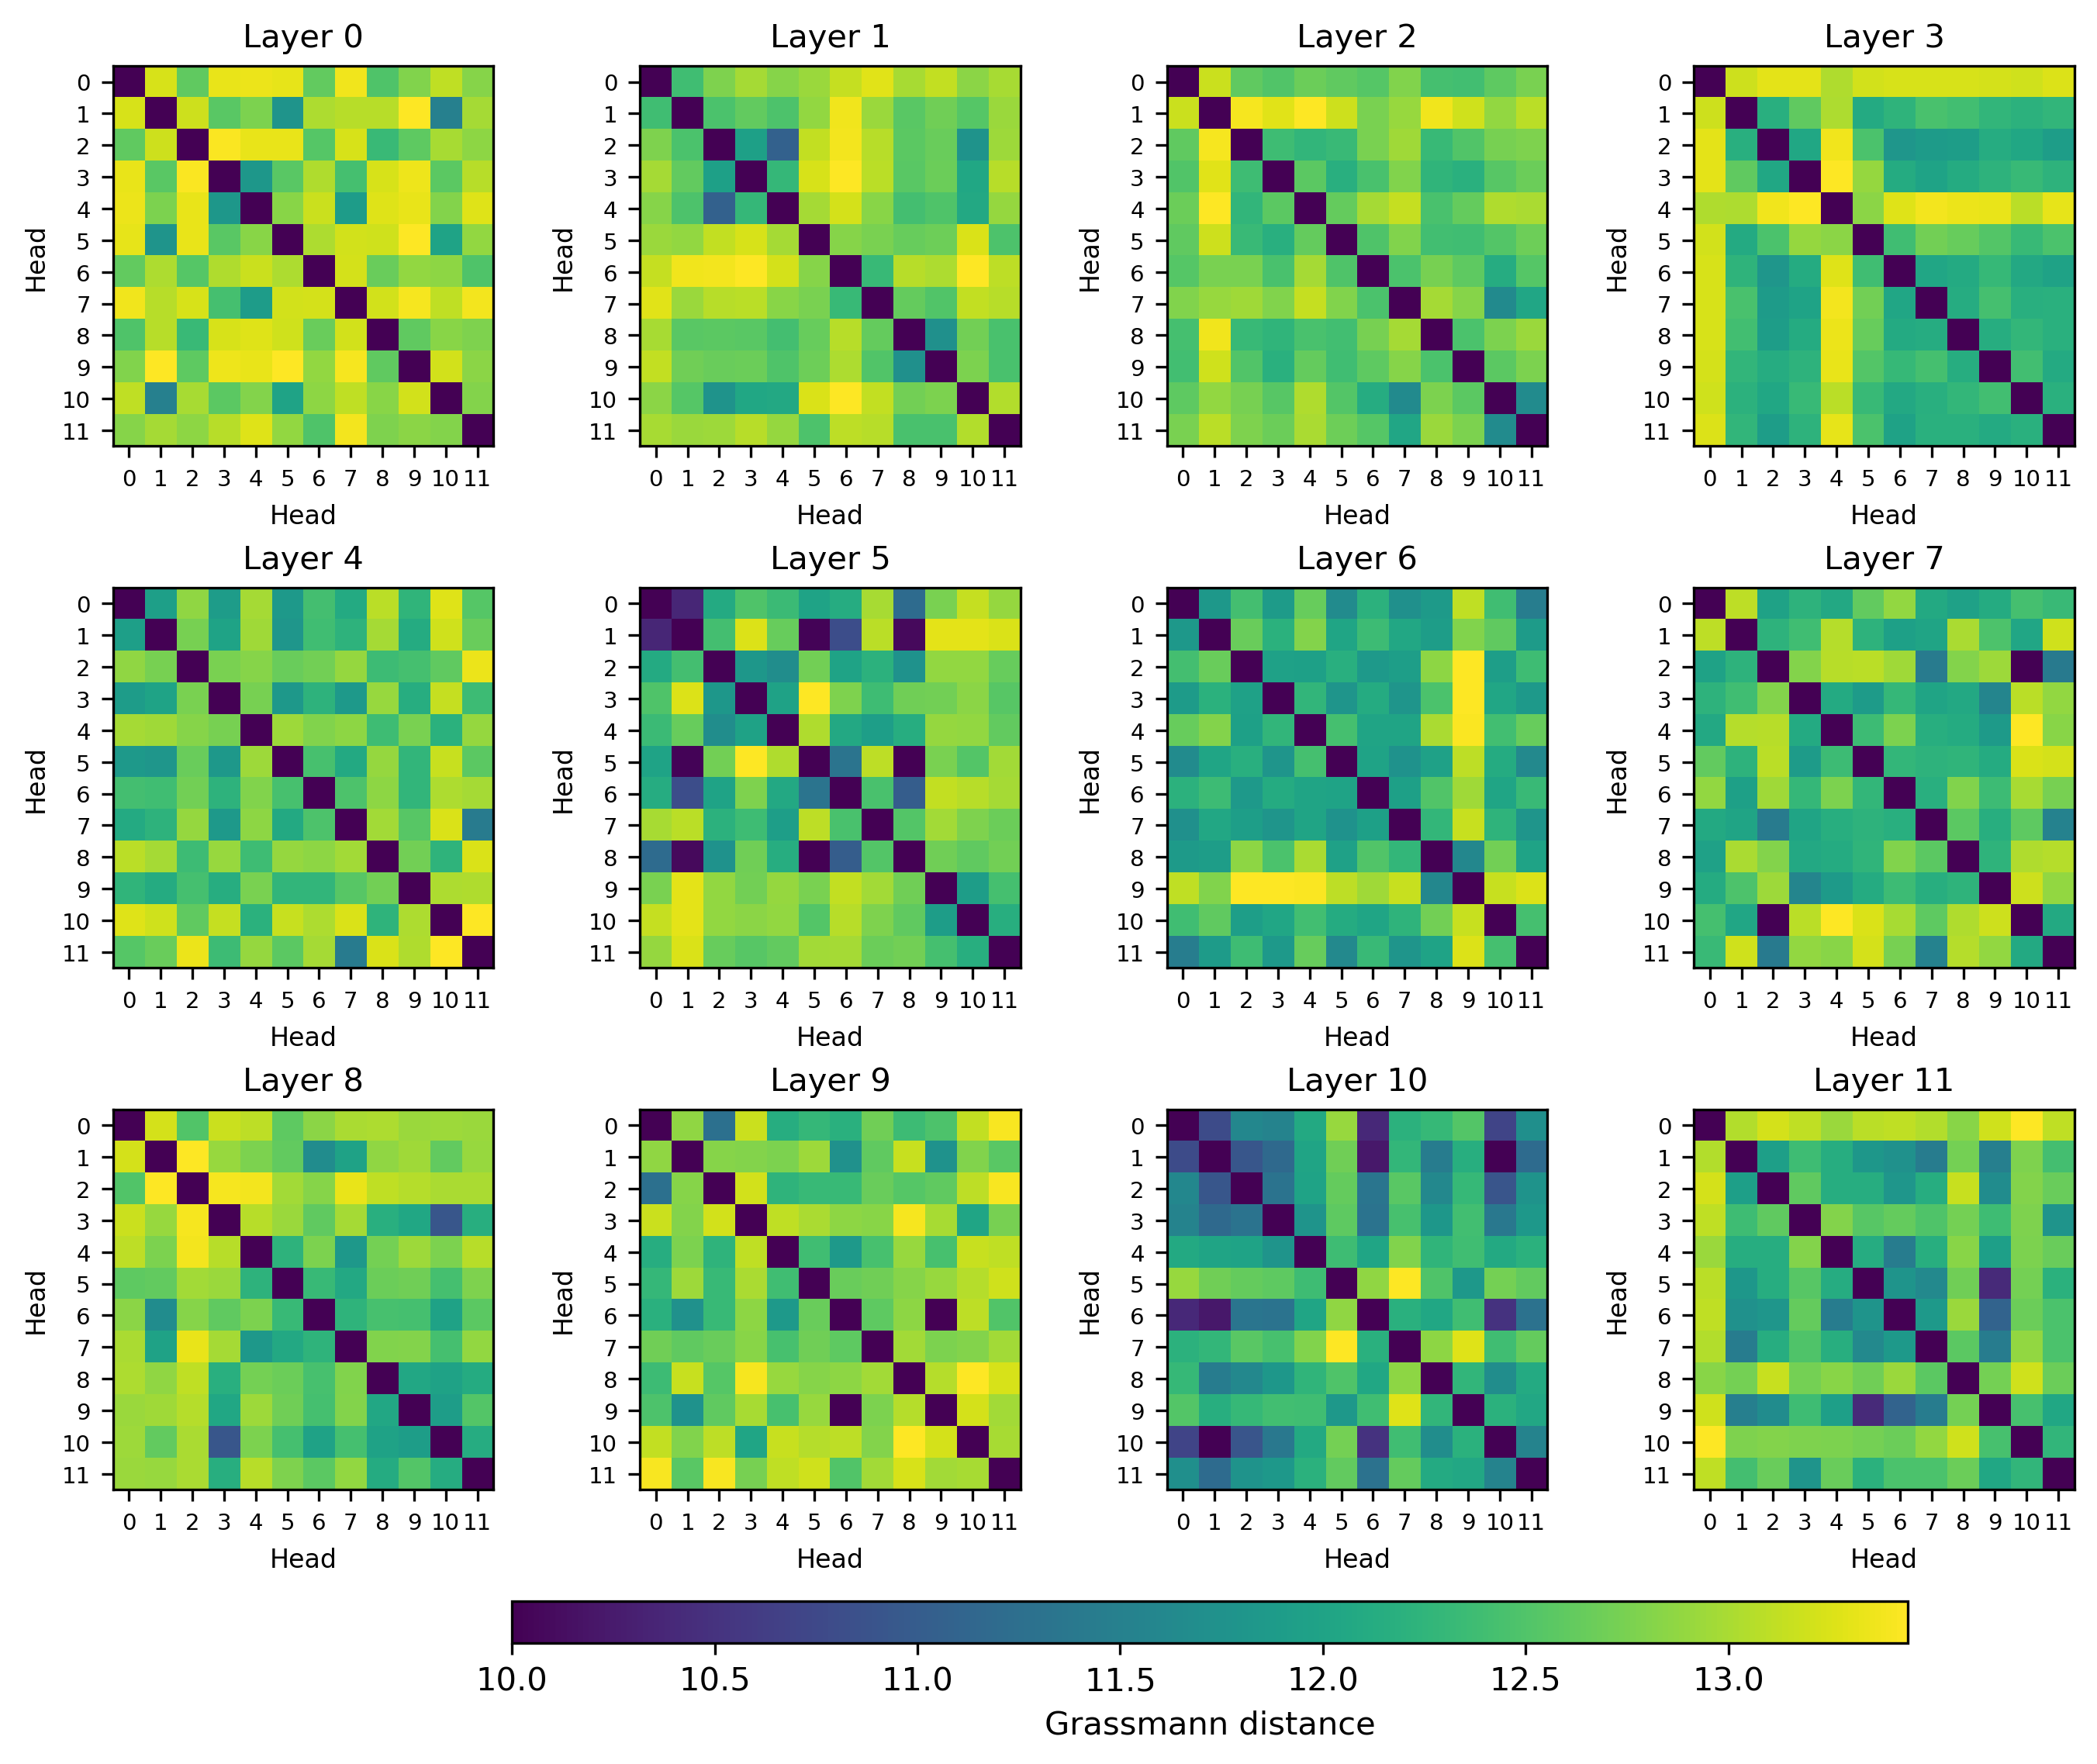

In [19]:
treshold = 10

fig, axes = plt.subplots(3, 4, figsize=(10, 6), dpi=300)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(grassmann_layers[i], cmap='viridis', interpolation='nearest', vmin=treshold)
    ax.set_title(f"Layer {i}", fontsize=10)
    ax.set_xlabel("Head", fontsize=8)
    ax.set_ylabel("Head", fontsize=8)
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(12))
    ax.tick_params(axis='both', which='major', labelsize=7)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Grassmann distance')
plt.subplots_adjust(left=0, right=0.9, top=1.1, bottom=0.08)
plt.savefig("grassmann_distance_heads.pdf", dpi=300, bbox_inches='tight')
plt.show()